In [ ]:
# 1. Import Required Libraries
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
# 2. Mount Drive and Load Data
# ==============================
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/bitcoin.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10
std,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07
50%,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09
75%,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2713 entries, 2014-09-17 to 2022-02-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2713 non-null   float64
 1   High       2713 non-null   float64
 2   Low        2713 non-null   float64
 3   Close      2713 non-null   float64
 4   Adj Close  2713 non-null   float64
 5   Volume     2713 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 148.4 KB


In [ ]:
df.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


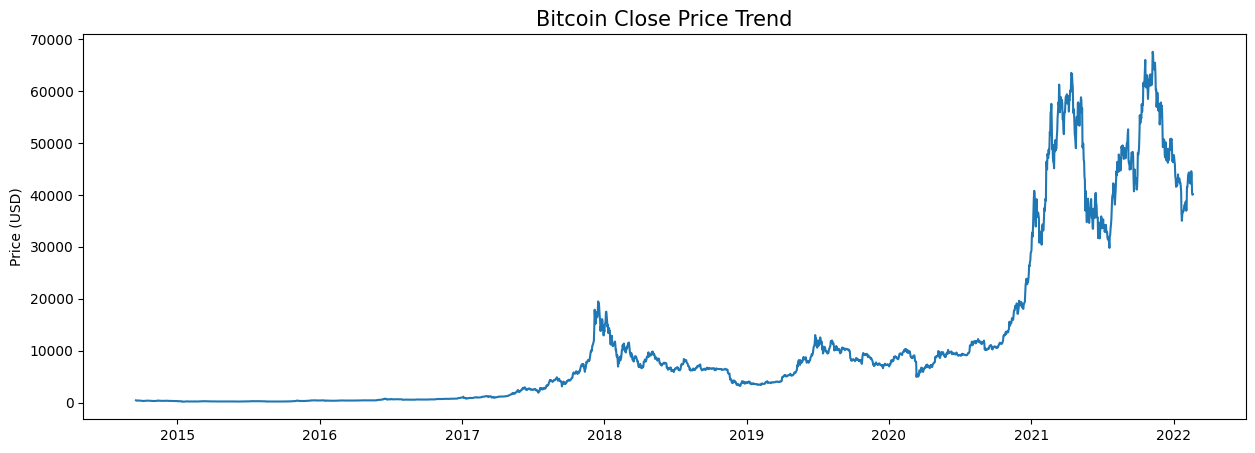

In [ ]:
# 4. Plot Close Price
# ==============================
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.title('Bitcoin Close Price Trend', fontsize=15)
plt.ylabel('Price (USD)')
plt.show()


In [ ]:
# 5. Technical Indicators
# ==============================
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
df['BB_Upper'] = df['BB_Middle'] + (df['Close'].rolling(window=20).std() * 2)
df['BB_Lower'] = df['BB_Middle'] - (df['Close'].rolling(window=20).std() * 2)

In [ ]:
# RSI
window = 14
delta = df['Close'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain).rolling(window=window).mean()
avg_loss = pd.Series(loss).rolling(window=window).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

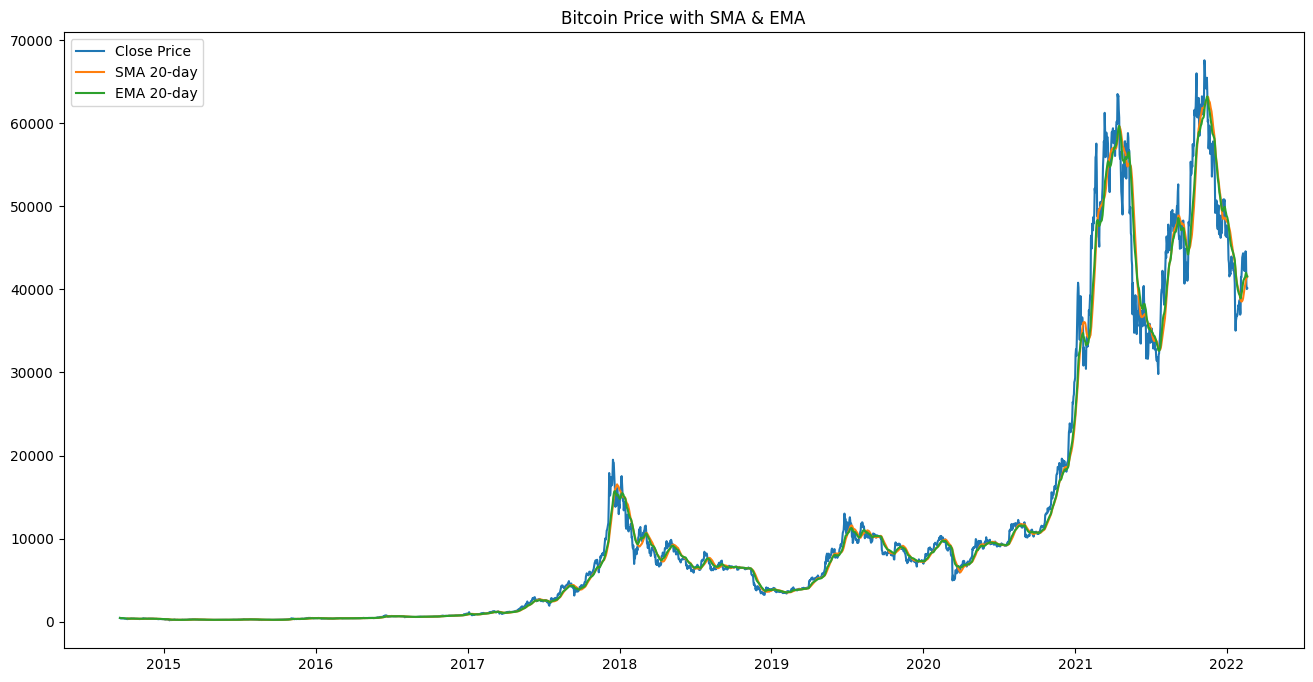

In [ ]:
# 6. Plot SMA, EMA & Bollinger Bands
# ==============================
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['SMA_20'], label='SMA 20-day')
plt.plot(df['EMA_20'], label='EMA 20-day')
plt.title('Bitcoin Price with SMA & EMA')
plt.legend()
plt.show()

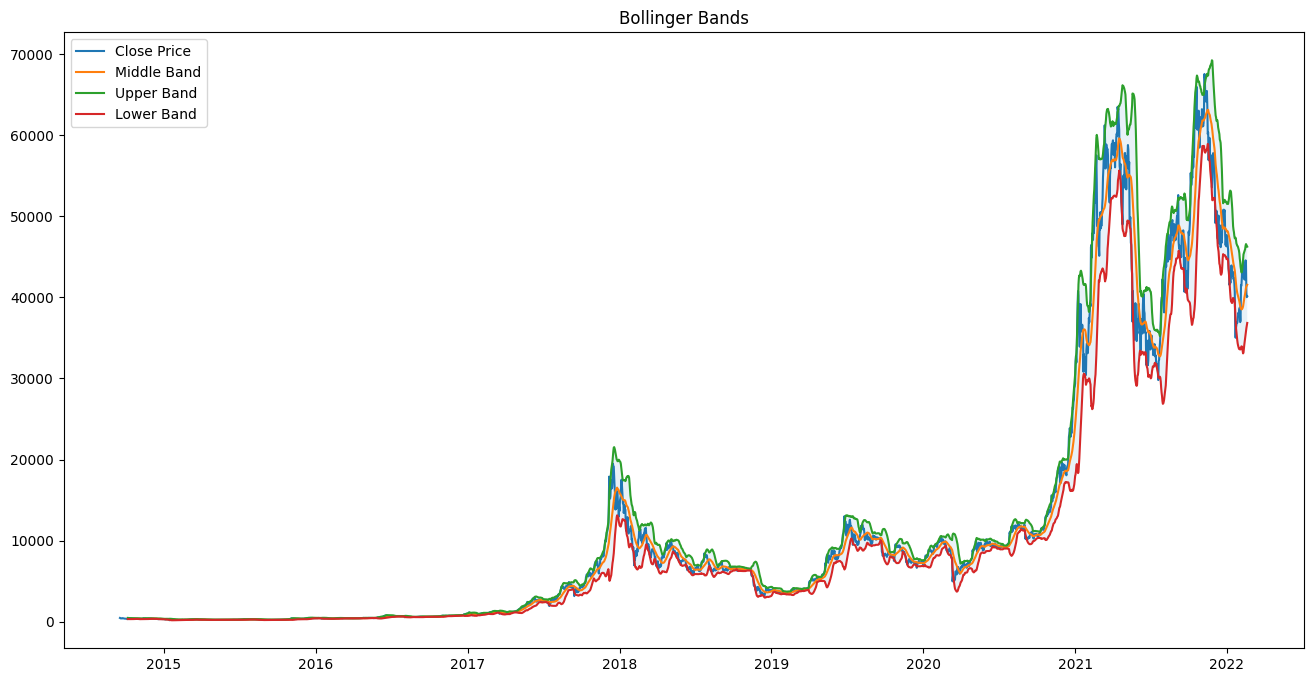

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['BB_Middle'], label='Middle Band')
plt.plot(df['BB_Upper'], label='Upper Band')
plt.plot(df['BB_Lower'], label='Lower Band')
plt.fill_between(df.index, df['BB_Lower'], df['BB_Upper'], alpha=0.1)
plt.title('Bollinger Bands')
plt.legend()
plt.show()

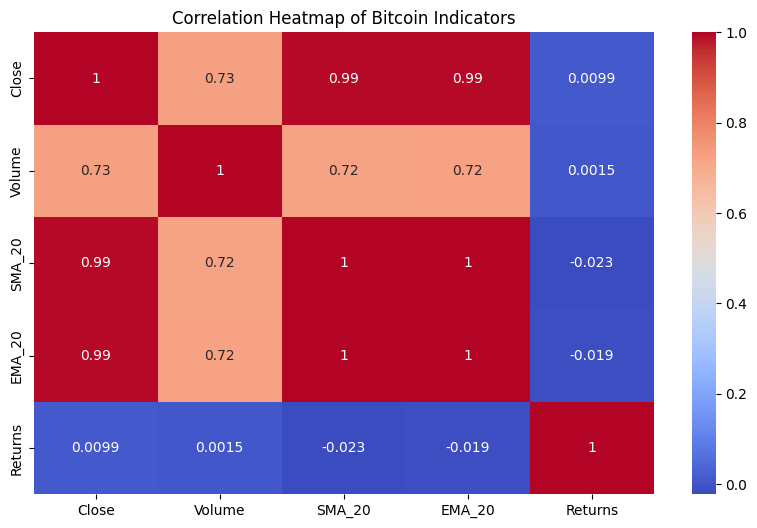

In [ ]:
# 7. Correlation Heatmap
# ==============================
df['Returns'] = df['Close'].pct_change()
corr_data = df[['Close', 'Volume', 'SMA_20', 'EMA_20', 'Returns']].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_data, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Bitcoin Indicators')
plt.show()

In [ ]:
# 8. Prepare Data for ML Models
# ==============================
df1 = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
df1['Target'] = df1['Close'].shift(-1)
df1.dropna(inplace=True)

X = df1[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df1['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 9. Linear Regression
# ==============================
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

print("\n=== LINEAR REGRESSION ===")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R²:", r2_score(y_test, y_pred_lr))


=== LINEAR REGRESSION ===
RMSE: 1632.8718771559716
R²: 0.989463816699399


In [ ]:
# 10. Random Forest
# ==============================
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("\n=== RANDOM FOREST ===")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R²:", r2_score(y_test, y_pred_rf))



=== RANDOM FOREST ===
RMSE: 26553.722604594113
R²: -1.7863131660332794


In [ ]:
# 11. SVM
# ==============================
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

print("\n=== SUPPORT VECTOR MACHINE ===")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_svm)))
print("R²:", r2_score(y_test, y_pred_svm))


=== SUPPORT VECTOR MACHINE ===
RMSE: 33163.82718861432
R²: -3.3461867742275704


In [ ]:
# 12. XGBoost
# ==============================
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

print("\n=== XGBOOST ===")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R²:", r2_score(y_test, y_pred_xgb))


=== XGBOOST ===
RMSE: 27548.199566588522
R²: -1.9989245532085667


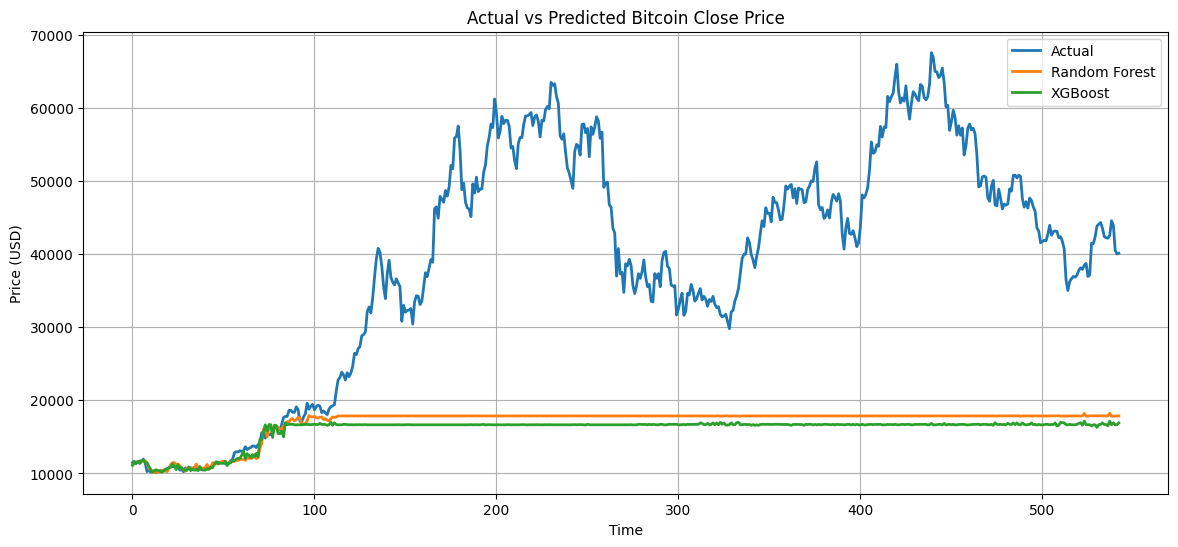

In [ ]:
# 13. Plot Actual vs Predicted
# ==============================
plt.figure(figsize=(14,6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred_rf, label='Random Forest', linewidth=2)
plt.plot(y_pred_xgb, label='XGBoost', linewidth=2)
plt.title('Actual vs Predicted Bitcoin Close Price')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 14. LSTM MODEL
# ==============================
# Select Close price only
data = df1[['Close']].values
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler_lstm.fit_transform(data)
scaled_data

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.64971932],
       [0.59891189],
       [0.59138785]])

In [ ]:
# Split into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]

In [ ]:
train_size

2169

In [ ]:
train_data
test_data

array([[0.13332816],
       [0.13158414],
       [0.13304123],
       [0.13374272],
       [0.1329583 ],
       [0.13429876],
       [0.1327419 ],
       [0.1322061 ],
       [0.13287661],
       [0.13200783],
       [0.13648235],
       [0.13465419],
       [0.13726673],
       [0.13503542],
       [0.13504788],
       [0.13447715],
       [0.13501364],
       [0.13452564],
       [0.1345197 ],
       [0.13377214],
       [0.13287274],
       [0.13315714],
       [0.13327062],
       [0.13366797],
       [0.13334765],
       [0.13647364],
       [0.13870659],
       [0.13953327],
       [0.13887768],
       [0.14095845],
       [0.1443426 ],
       [0.1604537 ],
       [0.15929549],
       [0.16208   ],
       [0.16223947],
       [0.16538915],
       [0.17186094],
       [0.16138473],
       [0.16424477],
       [0.16364443],
       [0.17167441],
       [0.17216041],
       [0.16951455],
       [0.17177863],
       [0.17061662],
       [0.17361967],
       [0.16668103],
       [0.169

In [ ]:
len(train_data)

2169

In [ ]:
# Prepare training data
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [ ]:
# Test
X_test, y_test_lstm = [], scaled_data[train_size:, 0]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
X_test = np.array(X_test).reshape(-1, 60, 1)

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.0018
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 1.7508e-04
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 1.6275e-04
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 1.6827e-04
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 1.4252e-04
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 1.1023e-04
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 1.0329e-04
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 9.8521e-05
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 1.0352e-04
Epoch 10/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 9.0236e-05
Epoch 11/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 1.1217e-04
Epoch 12/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 1.0399e-04
Epoch 13/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 1.0410e-04
Epoch 14/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 8.5718e-05
Epoch 15/20
66/66 ━━━━━━━━━━━━

In [ ]:
# Testing / Validation
# ==============================
X_test, y_test_lstm = [], scaled_data[train_size:, 0]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60:i, 0])

X_test = np.array(X_test).reshape(-1, 60, 1)

In [ ]:
X_test

array([[[0.13332816],
        [0.13158414],
        [0.13304123],
        ...,
        [0.17070693],
        [0.17045499],
        [0.17208357]],

       [[0.13158414],
        [0.13304123],
        [0.13374272],
        ...,
        [0.17045499],
        [0.17208357],
        [0.16602231]],

       [[0.13304123],
        [0.13374272],
        [0.1329583 ],
        ...,
        [0.17208357],
        [0.16602231],
        [0.16783609]],

       ...,

       [[0.69255909],
        [0.69045545],
        [0.69302653],
        ...,
        [0.62353773],
        [0.62931618],
        [0.65882089]],

       [[0.69045545],
        [0.69302653],
        [0.72354107],
        ...,
        [0.62931618],
        [0.65882089],
        [0.64971932]],

       [[0.69302653],
        [0.72354107],
        [0.71896907],
        ...,
        [0.65882089],
        [0.64971932],
        [0.59891189]]])

In [ ]:
# Predictions
predictions = model.predict(X_test)
predictions = scaler_lstm.inverse_transform(predictions)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step


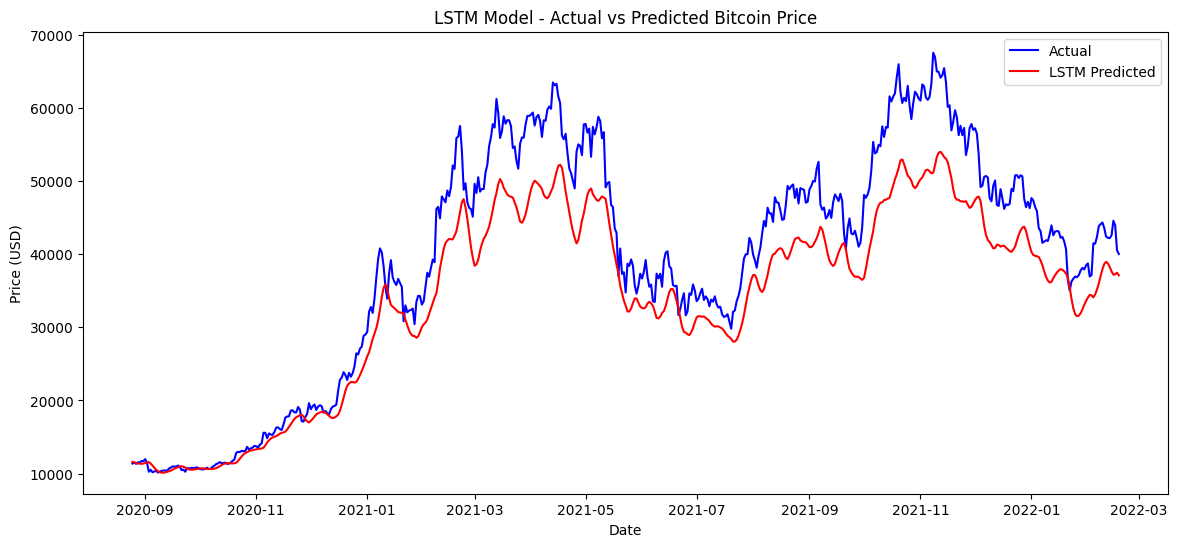

In [ ]:
# Plot Actual vs Predicted
# ==============================
plt.figure(figsize=(14, 6))
plt.plot(df1.index[train_size:], data[train_size:], label="Actual", color='blue')
plt.plot(df1.index[train_size:], predictions, label="LSTM Predicted", color='red')
plt.title("LSTM Model - Actual vs Predicted Bitcoin Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [ ]:
# 15. 60-Day Future Forecast
# ==============================
future_days = 60
future_input = scaled_data[-60:].reshape(1, 60, 1)
future_scaled = []

for _ in range(future_days):
    next_pred = model.predict(future_input)[0, 0]
    future_scaled.append(next_pred)
    new_input = np.append(future_input[0, 1:, 0], next_pred).reshape(1, 60, 1)
    future_input = new_input

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

In [ ]:
# Inverse transform future predictions
future_preds = scaler_lstm.inverse_transform(np.array(future_scaled).reshape(-1, 1))

In [ ]:
# Create future forecast DataFrame with sequential day numbers
future_df = pd.DataFrame({
    'Day Ahead': np.arange(1, future_days + 1),
    'Predicted Close Price (USD)': future_preds.flatten()
})

In [ ]:
# Print the first 10 and last 10 predicted days
print("\n🔮 Next 10 Predicted Days:")
print(future_df.head(10))
print("\n🔮 Last 10 Predicted Days:")
print(future_df.tail(10))


🔮 Next 10 Predicted Days:
   Day Ahead  Predicted Close Price (USD)
0          1                 36495.441406
1          2                 35224.453125
2          3                 33669.027344
3          4                 32012.312500
4          5                 30366.486328
5          6                 28798.255859
6          7                 27345.166016
7          8                 26025.701172
8          9                 24845.746094
9         10                 23802.787109

🔮 Last 10 Predicted Days:
    Day Ahead  Predicted Close Price (USD)
50         51                 13049.448242
51         52                 12963.209961
52         53                 12879.948242
53         54                 12799.517578
54         55                 12721.789062
55         56                 12646.638672
56         57                 12573.962891
57         58                 12503.658203
58         59                 12435.633789
59         60                 12369.800781


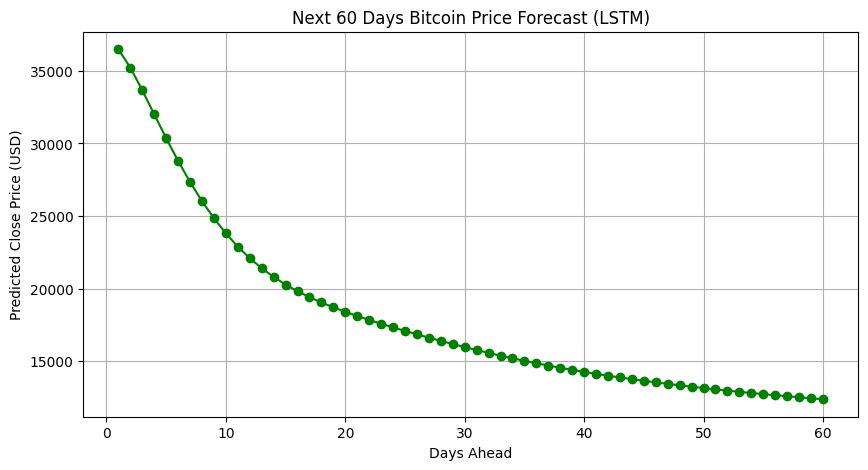

In [ ]:
# Plot future forecast (same style as before)
plt.figure(figsize=(10, 5))
plt.plot(future_df['Day Ahead'], future_df['Predicted Close Price (USD)'],
         marker='o', color='green')
plt.title("Next 60 Days Bitcoin Price Forecast (LSTM)")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Close Price (USD)")
plt.grid(True)
plt.show()